## Test surface magma ocean for sub-Neptune conditions

In [1]:
# Import system packages
using Printf
using DelimitedFiles
using Plots
using LaTeXStrings

In [2]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")

"/Users/nichollsh/Projects/AGNI/socrates"

In [3]:
# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.solver as nl
import AGNI.setpt as setpt
import AGNI.dump as dump
import AGNI.plotting as plotting

# Disable logging from AGNI module
AGNI.setup_logging("",1)

[ Info: Precompiling AGNI [ede838c1-9ec3-4ebe-8ae8-da4091b3f21c]


In [4]:
L_sun   = 3.83e26
R_earth = 6.371e6
M_earth = 5.97e24

5.97e24

In [5]:
# Get instellation [W m-2] given distance [AU] and star luminosity [L_sun]
function get_solar_flux(L::Float64, d::Float64)::Float64
    return L * L_sun / (4 * pi * d^2 * 1.496e11^2)
end 

get_solar_flux (generic function with 1 method)

In [6]:
# Configuration options
L_star          = 0.0194
instellation    = 1e5
mass            = 4.78*M_earth
radius          = 2*R_earth     
gravity         = 6.67e-11 * mass / radius^2
p_surf          = 2e4        

s0_fact         = 0.375  
zenith_degrees  = 48.19 
albedo_b        = 0.0
nlev_centre     = 40
p_top           = 1e-5      # bar 
mole_fractions  = Dict([
                        ("H2O", 0.05),
                        ("H2",  0.95)
                    ])
tmp_surf        = 3500.0
thermo          = true

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/nogit/Dayspring/256/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/trappist-1.txt")
output_dir    = joinpath(ROOT_DIR,"out/")

"/Users/nichollsh/Projects/AGNI/out/"

In [7]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

In [8]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir, 
                        spectral_file,
                        instellation, s0_fact, albedo_b, zenith_degrees,
                        tmp_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        thermo_functions=thermo
                    )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Composition set by dict 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocated atmosphere with composition: 
[ INFO  ]       1 H2O     5.00e-02  
[ INFO  ]       2 H2      9.50e-01  


In [9]:
setpt.dry_adiabat!(atmos)
setpt.stratosphere!(atmos, 2000.0)

In [10]:
solver_success = nl.solve_energy!(atmos, 
                                    sol_type=1,       
                                    sens_heat=true,   
                                    latent=true,      
                                    method=1,         
                                    dx_max=600.0,     
                                    linesearch=false , 
                                    save_frames=false, modplot=1,
                                    conv_atol=0.5,
                                    modprint=2
                                    )
println("Solver success? $solver_success")
atm_base = deepcopy(atmos);

[ INFO  ]     sol_type = 1 
[ INFO  ]     tmp_surf = 3500.00 K 
[ INFO  ]     step  resid_med    cost     flux_OLR   xvals_med  xvals_max  |dx|_max   flags 
[ INFO  ]        2  +6.29e-01  2.379e+05  2.912e+05  +1.52e+03  +3.50e+03  6.000e+02  C2-Nr 
[ INFO  ]        4  +6.46e-01  1.752e+07  4.603e+04  +1.15e+03  +3.50e+03  2.664e+02  C2-Nr 
[ INFO  ]        6  +3.43e-03  5.860e+05  2.688e+04  +1.11e+03  +3.50e+03  1.462e+02  C2-Nr 
[ INFO  ]        8  +5.17e-04  2.163e+04  2.497e+04  +1.11e+03  +3.50e+03  3.568e+01  C2-Nr 
[ INFO  ]       10  +3.98e-08  8.049e+02  2.491e+04  +1.11e+03  +3.50e+03  2.532e-01  C2-Nr 
[ INFO  ]       12  +6.98e-10  4.486e+01  2.491e+04  +1.11e+03  +3.50e+03  2.016e-02  C2-Nr 
[ INFO  ]       14  +1.45e-09  4.485e+01  2.491e+04  +1.11e+03  +3.50e+03  1.157e-02  C2-Nr 
[ INFO  ]       16  +2.04e-09  4.482e+01  2.491e+04  +1.11e+03  +3.50e+03  3.249e-02  C2-Nr 
[ INFO  ]       18  -4.82e-07  1.185e-01  2.491e+04  +1.11e+03  +3.50e+03  1.027e+01  C2-Nr 
[ INFO

In [11]:
dst_arr = collect(range(start=0.01, stop=0.08, step=0.01))
atm_arr = atmosphere.Atmos_t[]

@printf("Running model for %d samples... \n", length(dst_arr))

atmos = deepcopy(atm_base)
for (i,dst) in enumerate(dst_arr)
    @printf("sample %d \n",i)
    @printf("    distance = %.4f AU \n",dst)

    atmos.instellation = get_solar_flux(L_star, dst)
    @printf("    instellation = %.2e W m-2 \n", atmos.instellation)
    
    # Run model
    solver_success = nl.solve_energy!(atmos, 
                                    sol_type=3,         
                                    sens_heat=true,   
                                    latent=true,        
                                    method=1,           
                                    dx_max=400.0,        # Smaller steps
                                    linesearch=true ,   
                                    save_frames=false, modplot=1,
                                    modprint=1, perturb_all=true,
                                    conv_atol=0.4  
                                    )

    # Density 
    atmosphere.calc_observed_rho!(atmos)
    @printf("    observed density = %.5f g cm-3 \n", atmos.transspec_rho * 0.001)

    # Store result
    push!(atm_arr, deepcopy(atmos))
    @printf("--------------------------------- \n")
end 
println("Done!")

Running model for 8 samples... 
sample 1 
    distance = 0.0100 AU 
    instellation = 2.64e+05 W m-2 
[ INFO  ]     sol_type = 3 
[ INFO  ]     tmp_int  = 0.00 K 
[ INFO  ]     f_int    = 0.00 W m-2 
[ INFO  ]     step  resid_med    cost     flux_OLR   xvals_med  xvals_max  |dx|_max   flags 
[ INFO  ]        1  +4.57e-01  1.202e+04  6.130e+04  +1.16e+03  +3.30e+03  3.465e+02  C2-Nr-Ls 
[ INFO  ]        2  +5.58e-01  4.566e+03  6.854e+04  +1.23e+03  +3.02e+03  2.849e+02  C2-Nr-Ls 
[ INFO  ]        3  +2.60e-01  1.651e+03  6.741e+04  +1.32e+03  +2.73e+03  2.890e+02  C2-Nr-Ls 
[ INFO  ]        4  +8.66e-02  2.862e+02  6.605e+04  +1.36e+03  +2.43e+03  2.947e+02  C2-Nr-Ls 
[ INFO  ]        5  +3.15e-03  1.061e+01  6.577e+04  +1.36e+03  +2.19e+03  2.425e+02  C2-Nr-Ls 
[ INFO  ]        6  -1.20e-02  4.478e+00  6.576e+04  +1.36e+03  +1.99e+03  2.073e+02  C2-Nr-Ls 
[ INFO  ]        7  -6.87e-04  1.701e+00  6.576e+04  +1.36e+03  +1.82e+03  1.623e+02  C2-Nr-Ls 
[ INFO  ]        8  +2.91e-04  9.3

In [12]:
fs=12
lw=1.5
ff="Times New Roman"

"Times New Roman"

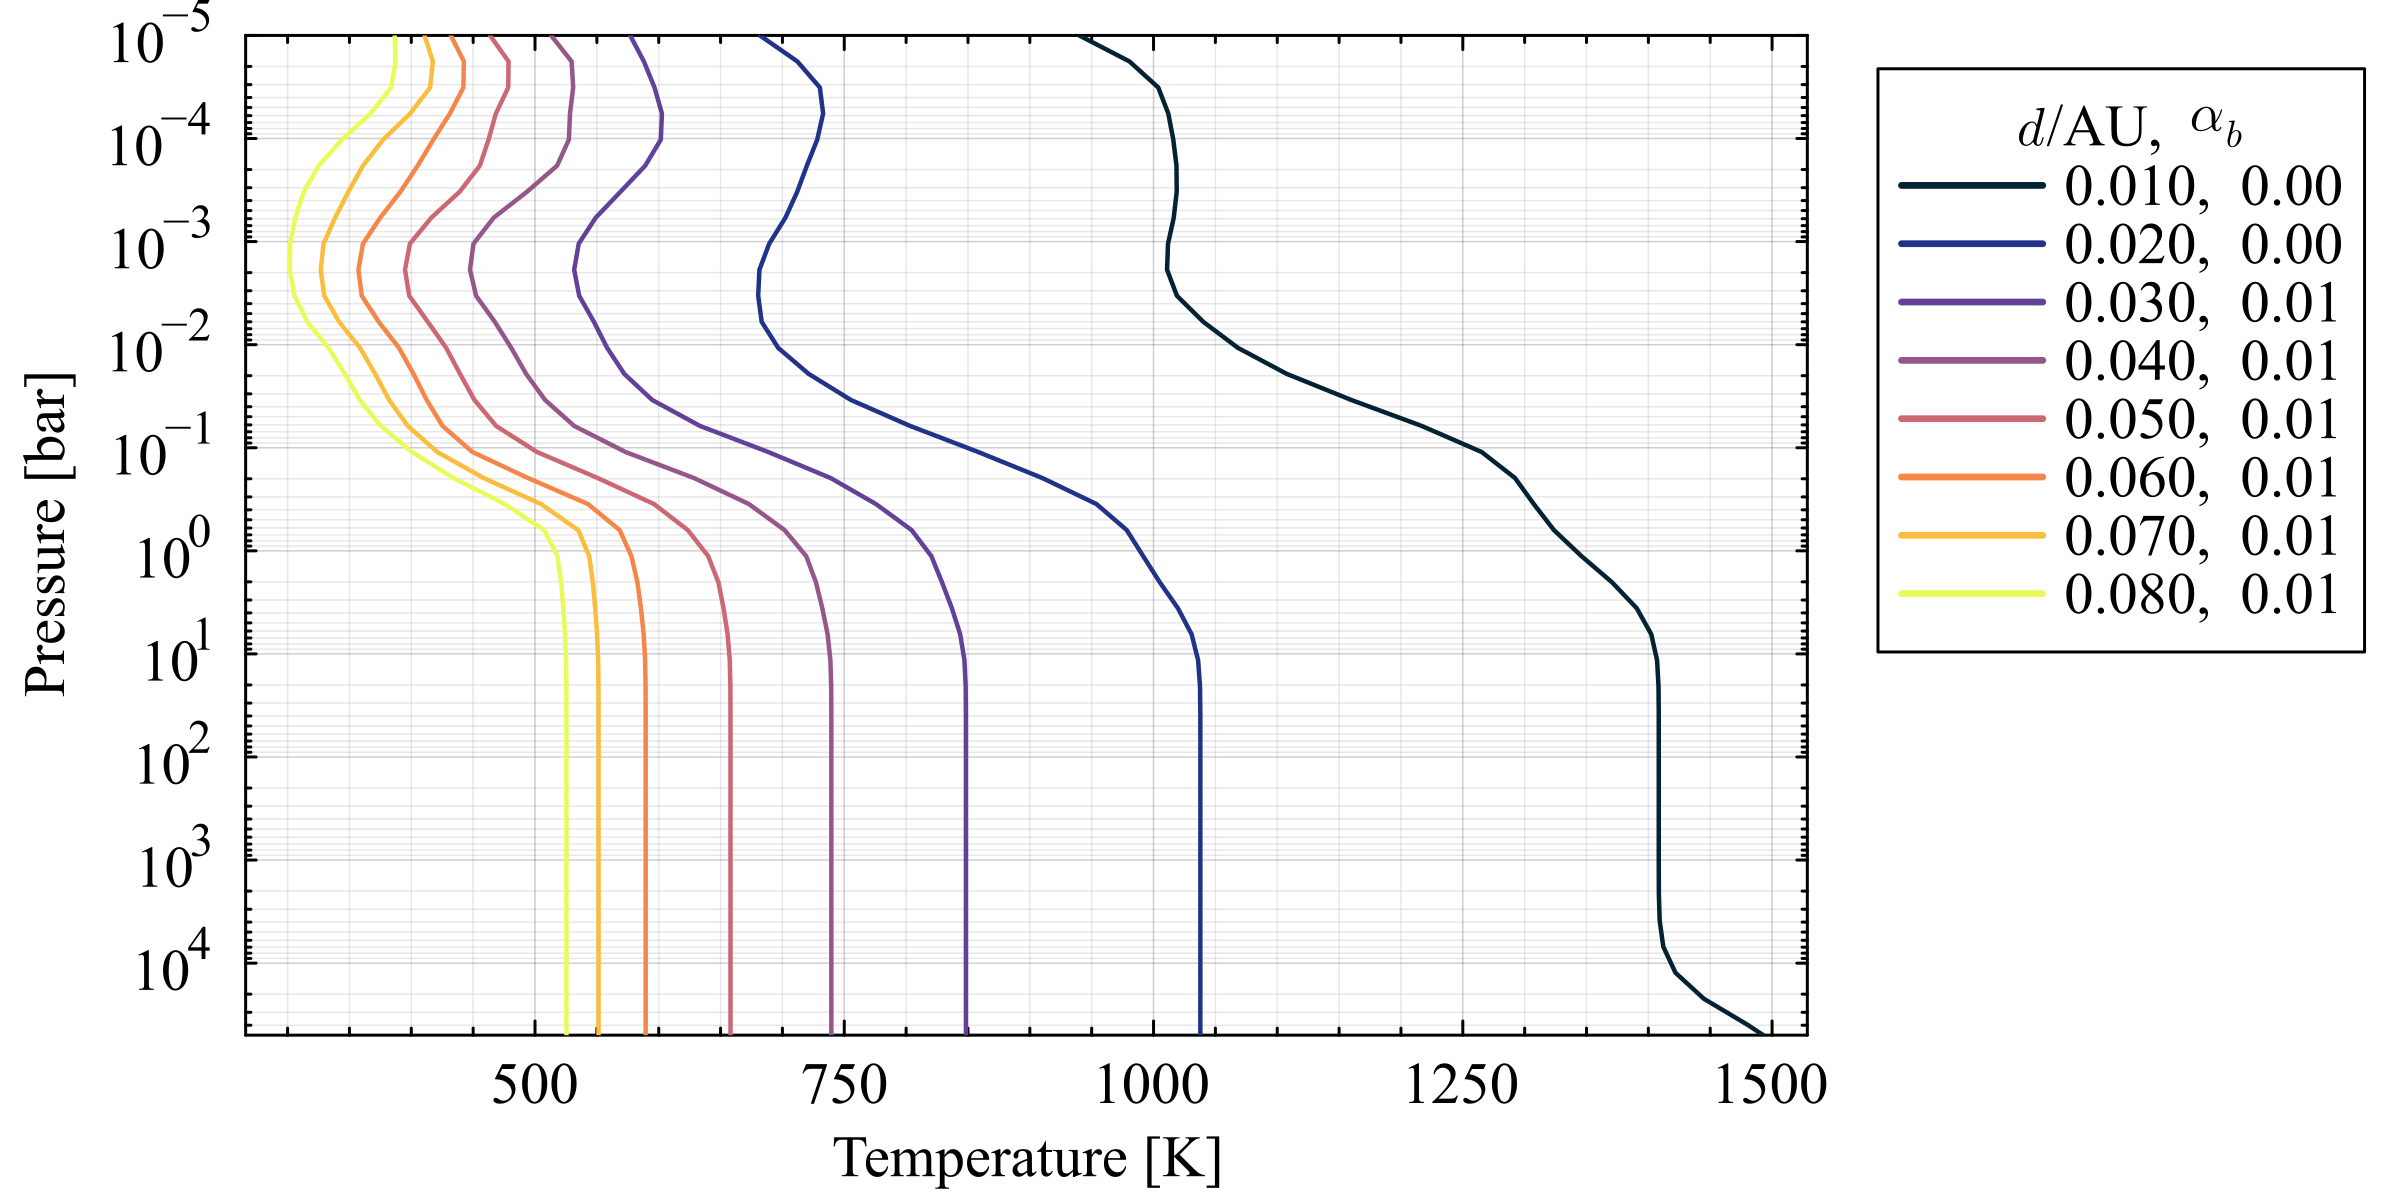

"/Users/nichollsh/Projects/AGNI/out/profiles.pdf"

In [13]:
arr_P = atmos.pl .* 1.0e-5 # Convert Pa to bar
ylims  = (arr_P[1], arr_P[end])
yticks = 10.0 .^ round.(Int,range( log10(ylims[1]), stop=log10(ylims[2]), step=1))

plt = plot(framestyle=:box, size=(800,400), dpi=300, 
                leg=:outertopright, legcolumn=-1,
                tickfontsize=fs, tickfontfamily=ff,
                guidefontsize=fs, guidefontfamily=ff,
                legendfontfamily=ff, legendfontsize=fs, 
                legendtitlefontfamily=ff, legendtitlefontsize=fs,
                leg_title=L"$d$/AU,  $\alpha_b$",
                left_margin=4Plots.mm, bottom_margin=4Plots.mm)
          

p = Plots.palette(:thermal, length(dst_arr))
for (i,this_atm) in enumerate(atm_arr)
    plot!(plt, this_atm.tmpl, this_atm.pl* 1.0e-5, lc=p[i], linewidth=lw, label=@sprintf("%.3f,  %.2f", dst_arr[i], this_atm.flux_u_sw[1]/this_atm.flux_d_sw[1]))
end 

xlabel!(plt, "Temperature [K]")
xaxis!(plt, minorgrid=true)
ylabel!(plt, "Pressure [bar]")
yflip!(plt)
yaxis!(plt, yscale=:log10, ylims=ylims, yticks=yticks)
display(plt)
savefig(plt,joinpath(output_dir,"profiles.pdf"))

In [14]:
# for (i, atm) in enumerate(atm_arr)
#     dump.write_ncdf(atm, joinpath(atm.OUT_DIR, "$i.nc"))
# end